# Loading and processing the dataset

In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_image_minmax(inputPath):
    # initialize the list of column names in the CSV file and then
    # load it using Pandas
    cols = ["min", "max", "image_name","temperature","Cr","Co"]
    df = pd.read_csv(inputPath,header=None, names=cols)
    # return the data frame
    return df

def process_image_minmax(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["min", "max"]
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    # trainX = np.hstack([trainContinuous])
    # testX = np.hstack([testContinuous])
    # return the concatenated training and testing data
    trainX = np.array(trainContinuous)
    testX = np.array(testContinuous)
    return (trainX, testX)

def load_spinodal_images(df, inputPath):
    # initialize our images array (i.e., the house images themselves)
    images = []
    # loop over the indexes of the houses
    for i in df['image_name']:
        # find the the images for the spinodal
        #imagePath = inputPath + i
        imagePath = os.path.sep.join([inputPath, str(i)])
        #imagePath = os.path.join(inputPath,str(i))
        #imagePath = os.path.join(inputPath,i)
        image = cv2.imread(imagePath)
        #print(image.shape)
        image = cv2.resize(image,(64,64))
        images.append(image)
        #image = cv2.resize(image, (32, 32))
        #images.append(image)
    # return our set of images
    return np.array(images)

# Model development

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

# Compile the model

In [3]:
%%time
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

# import the necessary packages
from spinodalfunc import spinodal_datasets
from spinodalfunc import spinodal_models
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import argparse
import locale
import os
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", type=str, required=True,
# help="path to input dataset of spinodal images")
# args = vars(ap.parse_args())
path='/home/labuser/Spinodal-Data/Spinodal_Dataset'
# construct the path to the input .csv file that contains information
# on each sample in the dataset and then load the dataset
print("[INFO] loading images min-max...")
inputPath = os.path.sep.join([path, "SpinodalInfo.csv"])
df = load_image_minmax(inputPath)
print("Data shape")
print(df.shape)
# load the images and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading spinodal images...")
images = load_spinodal_images(df, path)
images = images / 255.0
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
#normalizer = preprocessing.Normalization()
#df["temperature"]=(df["temperature"]-df["temperature"].min())/(df["temperature"].max()-df["temperature"].min())
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
print("Train shape")
print(trainAttrX.shape)
print("Test shape")
print(testAttrX.shape)
# find the largest temperature in the training set and use it to
# scale our temperatures to the range [0, 1] (will lead to better
# training and convergence)
maxTemp = trainAttrX["temperature"].max()
trainY = trainAttrX["temperature"] / maxTemp
testY = testAttrX["temperature"] / maxTemp
# process the image minmax data by performing min-max scaling
(trainAttrX, testAttrX) = process_image_minmax(df,trainAttrX, testAttrX)
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted temperature of the spinodal)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our temperature *predictions* and the *actual temperatures*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
history=model.fit(
    x=[trainAttrX, trainImagesX], y=trainY,
    validation_data=([testAttrX, testImagesX], testY),
    epochs=5000, batch_size=8,verbose=0)
# make predictions on the testing data
print("[INFO] predicting temperatures...")
preds = model.predict([testAttrX, testImagesX])
print("Temperature accuracy ...")
print("R-squared:")
print(r2_score(testY, preds))
print("MSE:")
print(mean_squared_error(testY, preds))
#print("Actual Temperature...")
#print(testY)
#print("Predicted Temperature...")
#print(preds)
# compute the difference between the *predicted* temperatures and the
# *actual* temperatures, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. temperature: {}, std temperature: {}".format(df["temperature"].mean(),df["temperature"].std()))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] loading images min-max...
Data shape
(454, 6)
[INFO] loading spinodal images...
[INFO] processing data...
Train shape
(340, 6)
Test shape
(114, 6)
[INFO] training model...
[INFO] predicting temperatures...
Temperature accuracy ...
R-squared:
0.8704553391607157
MSE:
0.0001423271872325324
[INFO] avg. temperature: 912.4713656387665, std temperature: 32.33629607121891
[INFO] mean: 0.91%, std: 0.88%
CPU times: user 24min 50s, sys: 2min 15s, total: 27min 6s
Wall time: 15min 30s


In [4]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

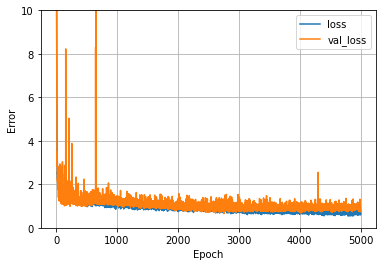

In [5]:
plot_loss(history)

In [6]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          activation[0][0]                 
_______________________________________________________________________________________

In [7]:
def parity_plot(x, y):
  plt.scatter(x, y, label='Data')
  #plt.plot(x, x, color='k', label='Predictions')
#   plt.xlabel('Ground truth')
#   plt.ylabel('Predicted')
  lims = [0.9*963, 980]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)
  plt.xlabel('Groud truth', fontsize=18)
  plt.ylabel('Prediction', fontsize=18)
  plt.legend()

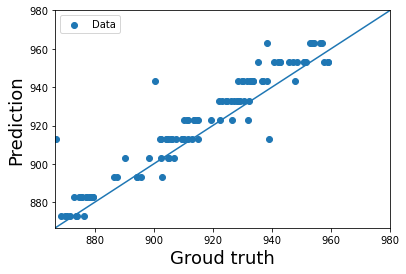

In [8]:
parity_plot(preds*df["temperature"].max(), testY*df["temperature"].max())

In [9]:
df

,min,max,image_name,temperature,Cr,Co
0,0.087996,0.359008,cr0.25_co0.45_T933.jpg,933,0.25,0.45
1,0.105033,0.336961,cr0.25_co0.45_T923.jpg,923,0.25,0.45
2,0.076472,0.289703,cr0.25_co0.5_T913.jpg,913,0.25,0.50
3,0.026899,0.137198,cr0.25_co0.65_T913.jpg,913,0.25,0.65
4,0.123865,0.390362,cr0.25_co0.4_T943.jpg,943,0.25,0.40
...,...,...,...,...,...,...
449,0.111756,0.391908,cr0.4_co0.35_T953.jpg,953,0.40,0.35
450,0.100258,0.329753,cr0.4_co0.4_T963.jpg,963,0.40,0.40
451,0.124840,0.389111,cr0.4_co0.35_T963.jpg,963,0.40,0.35
452,0.080774,0.267174,cr0.4_co0.45_T963.jpg,963,0.40,0.45
